In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, roc_auc_score
import xgboost

In [2]:
rates = np.arange(1,10,2)/10
print(rates)

[0.1 0.3 0.5 0.7 0.9]


### ECFP4

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem

def bit2np(bitvector):
    bitstring = bitvector.ToBitString()
    intmap = map(int, bitstring)
    return np.array(list(intmap))

def extract_morgan(smiles, targets):
    x,X,y = [],[],[]
    for sm,target in zip(smiles,targets):
        mol = Chem.MolFromSmiles(sm)
        if mol is None:
            continue
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) # Morgan (Similar to ECFP4)
        x.append(sm)
        X.append(bit2np(fp))
        y.append(target)
    return x,np.array(X),np.array(y)

### ST

In [4]:
import torch
from bert import BERT
from build_vocab import WordVocab
from utils import split

pad_index = 0
unk_index = 1
eos_index = 2
sos_index = 3
mask_index = 4

vocab = WordVocab.load_vocab('data/vocab.pkl')
model = BERT(len(vocab), hidden=256, n_layers=8, attn_heads=8, dropout=0)
model.load_state_dict(torch.load('../result/chembl/ep00_it010000.pkl'))
model.eval()

BERT(
  (embedding): BERTEmbedding(
    (token): TokenEmbedding(45, 256, padding_idx=0)
    (position): PositionalEmbedding()
    (segment): SegmentEmbedding(3, 256, padding_idx=0)
    (dropout): Dropout(p=0)
  )
  (transformer_blocks): ModuleList(
    (0): TransformerBlock(
      (attention): MultiHeadedAttention(
        (linear_layers): ModuleList(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): Linear(in_features=256, out_features=256, bias=True)
          (2): Linear(in_features=256, out_features=256, bias=True)
        )
        (output_linear): Linear(in_features=256, out_features=256, bias=True)
        (attention): Attention()
        (dropout): Dropout(p=0)
      )
      (feed_forward): PositionwiseFeedForward(
        (w_1): Linear(in_features=256, out_features=1024, bias=True)
        (w_2): Linear(in_features=1024, out_features=256, bias=True)
        (dropout): Dropout(p=0)
        (activation): GELU()
      )
      (input_sublayer): Sub

In [5]:
def get_inputs(sm):
    seq_len = 220
    sm = sm.split()
    if len(sm)>218:
        print('SMILES is too long ({:d})'.format(len(sm)))
        sm = sm[:218]
    ids = [vocab.stoi.get(token, unk_index) for token in sm]
    ids = [sos_index] + ids + [eos_index]
    seg = [1]*len(ids)
    padding = [pad_index]*(seq_len - len(ids))
    ids.extend(padding), seg.extend(padding)
    return ids, seg

def get_array(smiles):
    x_id, x_seg = [], []
    for sm in smiles:
        a,b = get_inputs(sm)
        x_id.append(a)
        x_seg.append(b)
    return torch.tensor(x_id), torch.tensor(x_seg)

def prepare_data(smiles):
    xid, xseg = get_array(smiles)
    st,ed = 0,100
    X = model.encode(xid[st:ed], xseg[st:ed]).detach().numpy()
    while ed<len(xid):
        st += 100
        ed += 100
        X = np.vstack([X, model.encode(xid[st:ed], xseg[st:ed]).detach().numpy()])
    X = np.hstack([np.mean(X, axis=1)[:,-256:], np.max(X, axis=1)[:,-256:], X[:,0,-512:] ]) # 最終層のmean, max, 最終2層の0番目
    return X

### GraphConv

In [4]:
import os
import deepchem as dc
from deepchem.models.tensorgraph.models.graph_models import GraphConvModel

# Evaluation

In [6]:
def evaluate_mlp_regression(X, y, rate, n_repeats):
    r2, rmse = np.empty(n_repeats), np.empty(n_repeats)
    for i in range(n_repeats):
        reg = MLPRegressor(max_iter=1000)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-rate)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        r2[i] = r2_score(y_pred, y_test)
        rmse[i] = mean_squared_error(y_pred, y_test)**0.5
    ret = {}
    ret['r2 mean'] = np.mean(r2)
    ret['r2 std'] = np.std(r2)
    ret['rmse mean'] = np.mean(rmse)
    ret['rmse std'] = np.std(rmse)
    return ret

## ESOL

In [7]:
df = pd.read_csv('data/esol.csv')
print(df.shape)
df.head()

(1128, 10)


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [8]:
x = df['smiles'].values
y = df['measured log solubility in mols per litre'].values

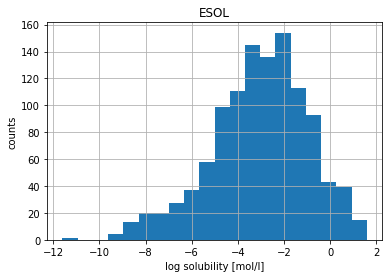

In [9]:
plt.hist(y, bins=20)
plt.xlabel('log solubility [mol/l]')
plt.ylabel('counts')
plt.title('ESOL')
plt.grid()
plt.show()

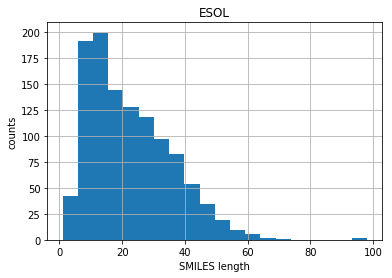

In [10]:
plt.hist(list(map(len, x)), bins=20)
plt.xlabel('SMILES length')
plt.ylabel('counts')
plt.title('ESOL')
plt.grid()
plt.show()

### ECFP4

In [11]:
x,X,y = extract_morgan(x,y)
print(len(X), len(y))

1128 1128


In [12]:
for rate in rates:
    score_dic = evaluate_mlp_regression(X, y, rate, 20)
    print(rate, score_dic)

0.1 {'r2 mean': -0.1182601549079639, 'r2 std': 0.38492231932689197, 'rmse mean': 1.7046461962569939, 'rmse std': 0.064028737168511}
0.3 {'r2 mean': 0.4200801070248882, 'r2 std': 0.056323869062615314, 'rmse mean': 1.5330984002474106, 'rmse std': 0.058330132808446886}
0.5 {'r2 mean': 0.5142260496738709, 'r2 std': 0.03488870888296532, 'rmse mean': 1.4796416953603162, 'rmse std': 0.04998929662590407}
0.7 {'r2 mean': 0.5517382840343468, 'r2 std': 0.04070523389695399, 'rmse mean': 1.4144024916614077, 'rmse std': 0.06294831164905162}
0.9 {'r2 mean': 0.6020391672882388, 'r2 std': 0.07006047612774513, 'rmse mean': 1.3241745714040831, 'rmse std': 0.10213747489123697}


In [13]:
0.1 {'r2 mean': -0.1182601549079639, 'r2 std': 0.38492231932689197, 'rmse mean': 1.7046461962569939, 'rmse std': 0.064028737168511}
0.3 {'r2 mean': 0.4200801070248882, 'r2 std': 0.056323869062615314, 'rmse mean': 1.5330984002474106, 'rmse std': 0.058330132808446886}
0.5 {'r2 mean': 0.5142260496738709, 'r2 std': 0.03488870888296532, 'rmse mean': 1.4796416953603162, 'rmse std': 0.04998929662590407}
0.7 {'r2 mean': 0.5517382840343468, 'r2 std': 0.04070523389695399, 'rmse mean': 1.4144024916614077, 'rmse std': 0.06294831164905162}
0.9 {'r2 mean': 0.6020391672882388, 'r2 std': 0.07006047612774513, 'rmse mean': 1.3241745714040831, 'rmse std': 0.10213747489123697}

SyntaxError: invalid syntax (<ipython-input-13-94519c8349cf>, line 1)

### ST

In [11]:
x_split = [split(sm) for sm in df['smiles'].values]
X = prepare_data(x_split)

In [12]:
X

array([[ 0.2992845 , -1.9981518 , -0.09136692, ...,  0.5290933 ,
         0.99185264, -0.553199  ],
       [ 0.5277692 , -2.5368433 ,  0.75767857, ...,  0.34645137,
         1.1052092 , -0.35453492],
       [-0.1009727 , -1.3521109 ,  0.13645627, ...,  0.61819124,
         0.9889748 , -0.9372664 ],
       ...,
       [-0.23300083, -1.8739034 ,  0.20166317, ...,  0.7312417 ,
         0.8450664 , -0.94042915],
       [-0.04621331, -1.4296285 ,  0.28007218, ...,  0.5092833 ,
         0.8324349 , -1.0037001 ],
       [ 0.14875588, -2.0599828 ,  0.18702924, ...,  0.7925967 ,
         1.2993927 , -0.57162243]], dtype=float32)

In [13]:
for rate in rates:
    score_dic = evaluate_mlp_regression(X, y, rate, 20)
    print(rate, score_dic)

/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.1 {'r2 mean': 0.6571610303680655, 'r2 std': 0.032572135933967246, 'rmse mean': 1.147067002227973, 'rmse std': 0.05359295019205026}
0.3 {'r2 mean': 0.696297613698292, 'r2 std': 0.040835502554000466, 'rmse mean': 1.0106739136248548, 'rmse std': 0.045704741851971334}
0.5 {'r2 mean': 0.690534623260907, 'r2 std': 0.06184343517089181, 'rmse mean': 1.0172932433069881, 'rmse std': 0.06902758468519067}
0.7 {'r2 mean': 0.716188339332361, 'r2 std': 0.04877404249436462, 'rmse mean': 0.9775043363906827, 'rmse std': 0.06428197359798228}
0.9 {'r2 mean': 0.6771786600248746, 'r2 std': 0.08891697359012948, 'rmse mean': 1.0246648545711594, 'rmse std': 0.12569763189365132}


### GraphConv

In [31]:
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(
      tasks=['measured log solubility in mols per litre'],
      smiles_field='smiles',
      featurizer=featurizer)
dataset = loader.featurize('data/esol.csv')

Loading raw samples now.
shard_size: 8192
About to start loading CSV from data/esol.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 3.531 s
TIMING: dataset construction took 4.218 s
Loading dataset from disk.


In [32]:
def evaluate_esol_gc(dataset, rate, n_repeats):
    r2, rmse = np.empty(n_repeats), np.empty(n_repeats)
    for i in range(n_repeats):
        reg = GraphConvModel(n_tasks=1, batch_size=64, mode='regression')
        splitter = dc.splits.RandomSplitter()
        train, val, _ = splitter.train_valid_test_split(dataset, frac_train=rate, frac_valid=1-rate, frac_test=0)
        reg.fit(train)
        metrics = [dc.metrics.Metric(dc.metrics.r2_score), dc.metrics.Metric(dc.metrics.rms_score)]
        scores = reg.evaluate(val, metrics)
        r2[i] = scores['r2_score']
        rmse[i] = scores['rms_score']
    ret = {}
    ret['r2 mean'] = np.mean(r2)
    ret['r2 std'] = np.std(r2)
    ret['rmse mean'] = np.mean(rmse)
    ret['rmse std'] = np.std(rmse)
    return ret

In [33]:
for rate in rates:
    score_dic = evaluate_esol_gc(dataset, rate, 20)
    print(rate, score_dic)

TIMING: dataset construction took 0.389 s
Loading dataset from disk.
TIMING: dataset construction took 0.897 s
Loading dataset from disk.
TIMING: dataset construction took 0.004 s
Loading dataset from disk.


/home/honda/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.3130601968068618]
computed_metrics: [1.7227710681805033]
TIMING: dataset construction took 0.380 s
Loading dataset from disk.
TIMING: dataset construction took 1.615 s
Loading dataset from disk.
TIMING: dataset construction took 0.004 s
Loading dataset from disk.
computed_metrics: [0.20640119096752885]
computed_metrics: [1.8676778579142235]
TIMING: dataset construction took 0.409 s
Loading dataset from disk.
TIMING: dataset construction took 0.943 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.2724772187268595]
computed_metrics: [1.7883851708039864]
TIMING: dataset construction took 0.398 s
Loading dataset from disk.
TIMING: dataset construction took 0.933 s
Loading dataset from disk.
TIMING: dataset construction took 0.004 s
Loading dataset from disk.
computed_metrics: [0.2502590705013873]
computed_metrics: [1.79821570706181]
TIMING: dataset construction took 0.390 s
Loading dataset from disk.

TIMING: dataset construction took 1.730 s
Loading dataset from disk.
TIMING: dataset construction took 0.004 s
Loading dataset from disk.
computed_metrics: [0.61452434660706]
computed_metrics: [1.3002474983333505]
TIMING: dataset construction took 0.515 s
Loading dataset from disk.
TIMING: dataset construction took 0.791 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.5975808099754454]
computed_metrics: [1.3324656450367918]
TIMING: dataset construction took 0.513 s
Loading dataset from disk.
TIMING: dataset construction took 0.787 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.5459675008442324]
computed_metrics: [1.394253001434885]
TIMING: dataset construction took 0.514 s
Loading dataset from disk.
TIMING: dataset construction took 0.795 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_m

computed_metrics: [0.5992053378034887]
computed_metrics: [1.3766943474339002]
TIMING: dataset construction took 1.605 s
Loading dataset from disk.
TIMING: dataset construction took 0.706 s
Loading dataset from disk.
TIMING: dataset construction took 0.004 s
Loading dataset from disk.
computed_metrics: [0.5755035397879957]
computed_metrics: [1.3936571401793403]
TIMING: dataset construction took 0.644 s
Loading dataset from disk.
TIMING: dataset construction took 0.640 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.5620000727297427]
computed_metrics: [1.4097571806686138]
0.5 {'r2 mean': 0.6608510694945265, 'r2 std': 0.06851655478404685, 'rmse mean': 1.2253566948338137, 'rmse std': 0.12372734445062651}
TIMING: dataset construction took 0.790 s
Loading dataset from disk.
TIMING: dataset construction took 1.512 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_met

computed_metrics: [0.7686597330541769]
computed_metrics: [1.0172851450732094]
TIMING: dataset construction took 0.955 s
Loading dataset from disk.
TIMING: dataset construction took 0.386 s
Loading dataset from disk.
TIMING: dataset construction took 0.002 s
Loading dataset from disk.
computed_metrics: [0.7839888188470655]
computed_metrics: [0.8928886720564172]
TIMING: dataset construction took 0.931 s
Loading dataset from disk.
TIMING: dataset construction took 0.388 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.8786960950326504]
computed_metrics: [0.6856912810455531]
TIMING: dataset construction took 0.965 s
Loading dataset from disk.
TIMING: dataset construction took 1.269 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.8435606136613938]
computed_metrics: [0.8668236262713546]
TIMING: dataset construction took 0.940 s
Loading dataset from disk

In [ ]:
0.1 {'r2 mean': 0.21890250990726204, 'r2 std': 0.07381879126556154, 'rmse mean': 1.8429856337306183, 'rmse std': 0.08739237277147067}
0.3 {'r2 mean': 0.5563064786186135, 'r2 std': 0.07246171936294994, 'rmse mean': 1.3880360761230484, 'rmse std': 0.1161028613690809}
0.5 {'r2 mean': 0.6608510694945265, 'r2 std': 0.06851655478404685, 'rmse mean': 1.2253566948338137, 'rmse std': 0.12372734445062651}
0.7 {'r2 mean': 0.7561302082858733, 'r2 std': 0.054626548782266596, 'rmse mean': 1.0387756727933906, 'rmse std': 0.12601494762902174}
0.9 {'r2 mean': 0.8148924716400823, 'r2 std': 0.03176142362012494, 'rmse mean': 0.8677234443263296, 'rmse std': 0.09109165427656797}

## Tox21

In [18]:
df = pd.read_csv('data/tox21.csv')
print(df.shape)
df.head()

(7831, 14)


,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O


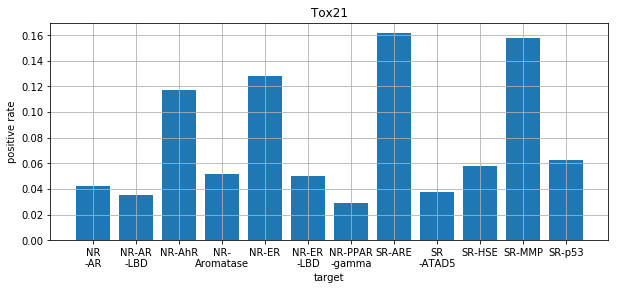

In [19]:
keys = df.keys()[:-2]
bottom = [df[k].mean() for k in keys]
keys = ['NR\n-AR', 'NR-AR\n-LBD', 'NR-AhR', 'NR-\nAromatase', 'NR-ER', 'NR-ER\n-LBD',
       'NR-PPAR\n-gamma', 'SR-ARE', 'SR\n-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']
plt.figure(figsize=(10,4))
plt.bar(keys, bottom)
plt.xlabel('target')
plt.ylabel('positive rate')
plt.title('Tox21')
plt.grid()
plt.show()

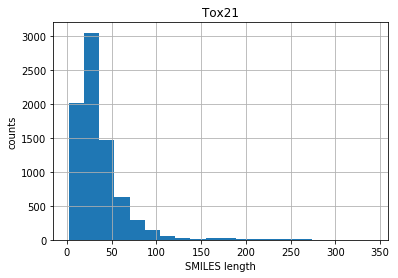

In [20]:
plt.hist(list(map(len, df['smiles'].values)), bins=20)
plt.xlabel('SMILES length')
plt.ylabel('counts')
plt.title('Tox21')
plt.grid()
plt.show()

In [25]:
from tqdm import tqdm_notebook as tqdm

def evaluate_classification_multi(X, y, rate, n_repeats):
    auc = np.empty(n_repeats)
    for i in tqdm(range(n_repeats)):
        clf = MLPClassifier(max_iter=1000)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-rate, stratify=y)
        clf.fit(X_train, y_train)
        y_score = clf.predict_proba(X_test)
        auc[i] = roc_auc_score(y_test, y_score[:,1])
        y_pred = clf.predict(X_test)
    ret = {}
    ret['auc mean'] = np.mean(auc)
    ret['auc std'] = np.std(auc)
    return ret

### ECFP4

In [26]:
for rate in rates:
    keys = df.keys()[:-2]
    n_tasks = len(keys)
    scores = np.empty((n_tasks, 2))
    for i,key in enumerate(keys):
        x = df['smiles'][df[key].isna()].values
        y = df[key].dropna().values
        x,X,y = extract_morgan(x, y)
        score_dic = evaluate_classification_multi(X, y, rate, 20)
        scores[i] = [score_dic['auc mean'], score_dic['auc std']]
    print(rate, np.mean(scores, axis=0))


0.1 [0.49014492 0.01986358]



0.3 [0.4883367  0.02578929]



0.5 [0.48641916 0.03304265]



0.7 [0.48915604 0.05061128]



0.9 [0.49556962 0.10761644]


### ST

In [28]:
x_split = [split(sm) for sm in df['smiles'].values]
x = prepare_data(x_split)
print('Encoding done')


SMILES is too long (231)
SMILES is too long (263)
SMILES is too long (277)
SMILES is too long (219)
SMILES is too long (325)
SMILES is too long (243)
SMILES is too long (271)
SMILES is too long (255)
SMILES is too long (251)
SMILES is too long (235)
SMILES is too long (227)
SMILES is too long (251)
SMILES is too long (248)
SMILES is too long (264)
SMILES is too long (311)
SMILES is too long (251)
SMILES is too long (340)
SMILES is too long (230)
SMILES is too long (306)
SMILES is too long (284)
SMILES is too long (233)
SMILES is too long (221)
SMILES is too long (253)
SMILES is too long (225)
SMILES is too long (264)
SMILES is too long (271)
SMILES is too long (226)
SMILES is too long (275)
SMILES is too long (225)
SMILES is too long (273)
Encoding done


TypeError: evaluate_classification_multi() takes 4 positional arguments but 5 were given

In [29]:
for rate in rates:
    keys = df.keys()[:-2]
    n_tasks = len(keys)
    scores = np.empty((n_tasks, 2))
    for i,key in enumerate(keys):
        X = x[df[key].notna()]
        y = df[key].dropna().values
        clf = MLPClassifier(max_iter=1000)
        score_dic = evaluate_classification_multi(X, y, rate, 20)
        scores[i] = [score_dic['auc mean'], score_dic['auc std']]
    print(rate, np.mean(scores, axis=0))


0.1 [0.72729178 0.01583617]



0.3 [0.75311616 0.01053973]



0.5 [0.76315039 0.0131799 ]



0.7 [0.76984735 0.02055655]



0.9 [0.77098238 0.03656447]


### GraphConv

In [10]:
df.keys()[:-2].values

array(['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER',
       'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE',
       'SR-MMP', 'SR-p53'], dtype=object)

In [46]:
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(
      tasks=list(df.keys()[:-2]),
      smiles_field='smiles',
      featurizer=featurizer)
dataset = loader.featurize('data/tox21.csv')

Loading raw samples now.
shard_size: 8192
About to start loading CSV from data/tox21.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
TIMING: featurizing shard 0 took 28.024 s
TIMING: dataset construction took 34.368 s
Loading dataset from disk.


In [49]:
def evaluate_classification_multi_dc(dataset, rate, n_repeats):
    roc = np.empty((n_repeats,12))
    for i in range(n_repeats):
        clf = GraphConvModel(n_tasks=len(df.keys())-2, batch_size=64, mode='classification')
        splitter = dc.splits.RandomStratifiedSplitter()
        train, val, _ = splitter.train_valid_test_split(dataset, frac_train=rate, frac_valid=1-rate, frac_test=0)
        clf.fit(train)
        metrics = [dc.metrics.Metric(dc.metrics.roc_auc_score)]
        scores = clf.evaluate(val, metrics)
        roc[i] = scores['roc_auc_score']
    ret = {}
    ret['roc mean'] = np.mean(roc)
    ret['roc std'] = np.mean(np.std(roc, axis=0))
    return ret

In [51]:
for rate in rates:
    score_dic = evaluate_classification_multi_dc(dataset, rate, 20)
    print(rate, score_dic)

TIMING: dataset construction took 0.603 s
Loading dataset from disk.
TIMING: dataset construction took 5.715 s
Loading dataset from disk.
TIMING: dataset construction took 5.583 s
Loading dataset from disk.


/home/honda/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.7181424438093222, 0.7455330316924753, 0.8313446856963973, 0.7286704023694179, 0.6565739616940207, 0.7170344177274871, 0.4985404922612866, 0.6591220154570182, 0.7182962712111871, 0.5803269162478881, 0.7794966168295903, 0.7434586840438049]
TIMING: dataset construction took 0.679 s
Loading dataset from disk.
TIMING: dataset construction took 5.848 s
Loading dataset from disk.
TIMING: dataset construction took 5.596 s
Loading dataset from disk.
computed_metrics: [0.7642455321428088, 0.797146849557826, 0.8133082339779096, 0.6796913454038787, 0.6718128379724744, 0.6933500531995744, 0.5667079489624133, 0.6694726169296314, 0.6856380322266431, 0.5591534213844096, 0.7756580964977424, 0.6916161852036966]
TIMING: dataset construction took 0.677 s
Loading dataset from disk.
TIMING: dataset construction took 5.847 s
Loading dataset from disk.
TIMING: dataset construction took 6.584 s
Loading dataset from disk.
computed_metrics: [0.7252449546525989, 0.780749571821941, 0.824868638

TIMING: dataset construction took 5.730 s
Loading dataset from disk.
TIMING: dataset construction took 5.626 s
Loading dataset from disk.
computed_metrics: [0.7681505074443623, 0.773399024786672, 0.8324772780405545, 0.7360864864064224, 0.6724599590873694, 0.6689470378233111, 0.5508632833400213, 0.6694552026922147, 0.6918067917843014, 0.589517442955273, 0.8024352848374591, 0.6899546177638911]
TIMING: dataset construction took 0.727 s
Loading dataset from disk.
TIMING: dataset construction took 5.734 s
Loading dataset from disk.
TIMING: dataset construction took 5.645 s
Loading dataset from disk.
computed_metrics: [0.729982513460034, 0.7783416082554517, 0.8130351936160418, 0.7311191874861902, 0.6434746717825097, 0.6994178462727667, 0.6832464203185606, 0.690813139948142, 0.726390214646818, 0.619804258735398, 0.8068210583724718, 0.722737157855268]
0.1 {'roc mean': 0.6975050137485098, 'roc std': 0.027513840142453033}
TIMING: dataset construction took 2.058 s
Loading dataset from disk.
TIMIN

TIMING: dataset construction took 2.187 s
Loading dataset from disk.
TIMING: dataset construction took 4.567 s
Loading dataset from disk.
TIMING: dataset construction took 4.472 s
Loading dataset from disk.
computed_metrics: [0.7874593097362487, 0.8225019162000049, 0.8556782917447854, 0.8187931274610349, 0.7055528474416728, 0.7963448847514905, 0.7536407519288075, 0.7453770463253222, 0.7553469484210396, 0.6824378605524324, 0.8595425122100926, 0.7497494350157481]
TIMING: dataset construction took 2.136 s
Loading dataset from disk.
TIMING: dataset construction took 4.251 s
Loading dataset from disk.
TIMING: dataset construction took 4.274 s
Loading dataset from disk.
computed_metrics: [0.7965383254999455, 0.8272679324894514, 0.8560051819021097, 0.8077703025097814, 0.6994979732448692, 0.7430082485956054, 0.7488209653947488, 0.7245472090261282, 0.763767832104316, 0.6583960973873292, 0.8347944063509687, 0.7669706708962907]
TIMING: dataset construction took 2.042 s
Loading dataset from disk.


TIMING: dataset construction took 3.217 s
Loading dataset from disk.
TIMING: dataset construction took 3.501 s
Loading dataset from disk.
TIMING: dataset construction took 3.346 s
Loading dataset from disk.
computed_metrics: [0.7695476617989156, 0.8356827007532572, 0.8782204536438853, 0.8095019024558976, 0.7220528545721772, 0.7944403575383641, 0.7920513501745374, 0.7619219163977609, 0.7982525809881498, 0.7220004550510668, 0.8765610410831, 0.7827377106179768]
TIMING: dataset construction took 4.051 s
Loading dataset from disk.
TIMING: dataset construction took 3.153 s
Loading dataset from disk.
TIMING: dataset construction took 3.240 s
Loading dataset from disk.
computed_metrics: [0.7873757655866891, 0.8597283993384588, 0.8601090350165186, 0.8339760993154659, 0.7306380413730655, 0.7958977434257285, 0.7963922952378877, 0.7451583542985994, 0.782197540676588, 0.7117466044142615, 0.8660844533736185, 0.8125691451095138]
TIMING: dataset construction took 3.201 s
Loading dataset from disk.
TIM

TIMING: dataset construction took 4.409 s
Loading dataset from disk.
TIMING: dataset construction took 2.094 s
Loading dataset from disk.
TIMING: dataset construction took 2.964 s
Loading dataset from disk.
computed_metrics: [0.8345443065411402, 0.8864921635159153, 0.8591847926348802, 0.8172577559108924, 0.7274285916289592, 0.8050808228562965, 0.8030042246909717, 0.7856875726716184, 0.8264985225833685, 0.7561805209888834, 0.8949262954139368, 0.834223161129249]
TIMING: dataset construction took 5.670 s
Loading dataset from disk.
TIMING: dataset construction took 1.883 s
Loading dataset from disk.
TIMING: dataset construction took 1.946 s
Loading dataset from disk.
computed_metrics: [0.7908251405597262, 0.8692397660818713, 0.8840817652293063, 0.8429283357899908, 0.7221888175896083, 0.8133552643503164, 0.7898958047710447, 0.7656579306078367, 0.7347229414810978, 0.7607575415632288, 0.8563084855815138, 0.7850059988717355]
TIMING: dataset construction took 4.500 s
Loading dataset from disk.


TIMING: dataset construction took 5.793 s
Loading dataset from disk.
TIMING: dataset construction took 0.808 s
Loading dataset from disk.
TIMING: dataset construction took 0.792 s
Loading dataset from disk.
computed_metrics: [0.8285198555956679, 0.8448940269749519, 0.8983454268151776, 0.8576519916142558, 0.7132832898172323, 0.9056291390728477, 0.7001240966493905, 0.758045922706227, 0.8699039780521263, 0.7428050463236744, 0.8981962052241981, 0.842077480278014]
TIMING: dataset construction took 5.769 s
Loading dataset from disk.
TIMING: dataset construction took 0.736 s
Loading dataset from disk.
TIMING: dataset construction took 0.755 s
Loading dataset from disk.
computed_metrics: [0.8691353815996932, 0.9532882241215574, 0.8443552608619787, 0.880952380952381, 0.722567287784679, 0.8124754033844943, 0.8887292673370772, 0.7703057644110276, 0.8247173972980424, 0.7788564818640007, 0.9123863760814808, 0.8444741346916622]
TIMING: dataset construction took 5.713 s
Loading dataset from disk.
TIM

## BACE

In [6]:
df = pd.read_csv('data/bace.csv')
print(df.shape)
df.head()

(1513, 595)


,mol,CID,Class,Model,pIC50,MW,AlogP,HBA,HBD,RB,...,PEOE6 (PEOE6),PEOE7 (PEOE7),PEOE8 (PEOE8),PEOE9 (PEOE9),PEOE10 (PEOE10),PEOE11 (PEOE11),PEOE12 (PEOE12),PEOE13 (PEOE13),PEOE14 (PEOE14),canvasUID
0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,BACE_1,1,Train,9.154901,431.56979,4.4014,3,2,5,...,53.205711,78.640335,226.85541,107.43491,37.133846,0.000000,7.980170,0.0,0.000000,1
1,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...,BACE_2,1,Train,8.853872,657.81073,2.6412,5,4,16,...,73.817162,47.171600,365.67694,174.07675,34.923889,7.980170,24.148668,0.0,24.663788,2
2,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_3,1,Train,8.698970,591.74091,2.5499,4,3,11,...,70.365707,47.941147,192.40652,255.75255,23.654478,0.230159,15.879790,0.0,24.663788,3
3,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...,BACE_4,1,Train,8.698970,591.67828,3.1680,4,3,12,...,56.657166,37.954151,194.35304,202.76335,36.498634,0.980913,8.188327,0.0,26.385181,4
4,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_5,1,Train,8.698970,629.71283,3.5086,3,3,11,...,78.945702,39.361153,179.71288,220.46130,23.654478,0.230159,15.879790,0.0,26.100143,5


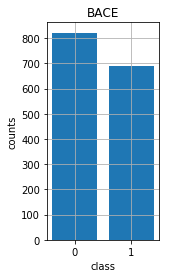

In [7]:
keys = ['0', '1']
bottom = df.groupby('Class').count()['CID'].values
plt.figure(figsize=(2,4))
plt.bar(keys, bottom)
plt.xlabel('class')
plt.ylabel('counts')
plt.title('BACE')
plt.grid()
plt.show()

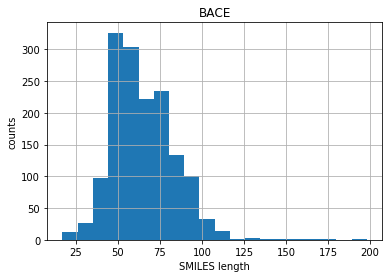

In [8]:
plt.hist(list(map(len, df['mol'].values)), bins=20)
plt.xlabel('SMILES length')
plt.ylabel('counts')
plt.title('BACE')
plt.grid()
plt.show()

In [16]:
def evaluate_mlp_classification(X, y, rate, n_repeats):
    auc = np.empty(n_repeats)
    for i in range(n_repeats):
        clf = MLPClassifier(max_iter=1000)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-rate, stratify=y)
        clf.fit(X_train, y_train)
        y_score = clf.predict_proba(X_test)
        auc[i] = roc_auc_score(y_test, y_score[:,1])
    ret = {}
    ret['auc mean'] = np.mean(auc)
    ret['auc std'] = np.mean(np.std(auc, axis=0))
    return ret

### ECFP4

### ST

In [11]:
x_split = [split(sm) for sm in df['mol'].values]
X = prepare_data(x_split)
y = df['Class']

In [17]:
for rate in rates:
    score_dic = evaluate_mlp_classification(X, y, rate, 20)
    print(rate, score_dic)

0.1 {'auc mean': 0.6958014686712436, 'auc std': 0.06957807864878243}
0.3 {'auc mean': 0.7304518910697888, 'auc std': 0.018850149900539386}
0.5 {'auc mean': 0.7506385103300844, 'auc std': 0.02061710048296944}
0.7 {'auc mean': 0.7561824013769093, 'auc std': 0.02300537593287118}
0.9 {'auc mean': 0.7612624410686222, 'auc std': 0.031042263179352075}


### GraphConv

In [53]:
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(
      tasks=['Class'],
      smiles_field='mol',
      featurizer=featurizer)
dataset = loader.featurize('data/bace.csv')

Loading raw samples now.
shard_size: 8192
About to start loading CSV from data/bace.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 9.385 s
TIMING: dataset construction took 11.598 s
Loading dataset from disk.


In [54]:
def evaluate_classification_single_dc(dataset, rate, n_repeats):
    roc = np.empty(n_repeats)
    for i in range(n_repeats):
        clf = GraphConvModel(n_tasks=1, batch_size=64, mode='classification')
        splitter = dc.splits.RandomStratifiedSplitter()
        train, val, _ = splitter.train_valid_test_split(dataset, frac_train=rate, frac_valid=1-rate, frac_test=0)
        clf.fit(train)
        metrics = [dc.metrics.Metric(dc.metrics.roc_auc_score)]
        scores = clf.evaluate(val, metrics)
        roc[i] = scores['roc_auc_score']
    ret = {}
    ret['roc mean'] = np.mean(roc)
    ret['roc std'] = np.std(roc)
    return ret

In [55]:
for rate in rates:
    score_dic = evaluate_classification_single_dc(dataset, rate, 20)
    print(rate, score_dic)

TIMING: dataset construction took 0.175 s
Loading dataset from disk.
TIMING: dataset construction took 1.667 s
Loading dataset from disk.
TIMING: dataset construction took 1.639 s
Loading dataset from disk.


/home/honda/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.7583669973684097]
TIMING: dataset construction took 0.187 s
Loading dataset from disk.
TIMING: dataset construction took 1.637 s
Loading dataset from disk.
TIMING: dataset construction took 1.562 s
Loading dataset from disk.
computed_metrics: [0.7826366559485529]
TIMING: dataset construction took 0.168 s
Loading dataset from disk.
TIMING: dataset construction took 1.708 s
Loading dataset from disk.
TIMING: dataset construction took 1.665 s
Loading dataset from disk.
computed_metrics: [0.7766688102893891]
TIMING: dataset construction took 0.191 s
Loading dataset from disk.
TIMING: dataset construction took 1.635 s
Loading dataset from disk.
TIMING: dataset construction took 1.569 s
Loading dataset from disk.
computed_metrics: [0.759090548211663]
TIMING: dataset construction took 0.166 s
Loading dataset from disk.
TIMING: dataset construction took 1.680 s
Loading dataset from disk.
TIMING: dataset construction took 1.606 s
Loading dataset from disk.
computed_metrics:

TIMING: dataset construction took 0.532 s
Loading dataset from disk.
TIMING: dataset construction took 1.305 s
Loading dataset from disk.
TIMING: dataset construction took 1.403 s
Loading dataset from disk.
computed_metrics: [0.8105472264905795]
TIMING: dataset construction took 0.541 s
Loading dataset from disk.
TIMING: dataset construction took 1.278 s
Loading dataset from disk.
TIMING: dataset construction took 1.234 s
Loading dataset from disk.
computed_metrics: [0.8108824718130252]
TIMING: dataset construction took 0.549 s
Loading dataset from disk.
TIMING: dataset construction took 1.216 s
Loading dataset from disk.
TIMING: dataset construction took 1.224 s
Loading dataset from disk.
computed_metrics: [0.8252462457613434]
TIMING: dataset construction took 0.517 s
Loading dataset from disk.
TIMING: dataset construction took 1.264 s
Loading dataset from disk.
TIMING: dataset construction took 1.266 s
Loading dataset from disk.
computed_metrics: [0.8225128510976683]
TIMING: dataset 

computed_metrics: [0.8756564720420141]
TIMING: dataset construction took 1.272 s
Loading dataset from disk.
TIMING: dataset construction took 0.496 s
Loading dataset from disk.
TIMING: dataset construction took 0.530 s
Loading dataset from disk.
computed_metrics: [0.8289316239316239]
TIMING: dataset construction took 1.281 s
Loading dataset from disk.
TIMING: dataset construction took 0.593 s
Loading dataset from disk.
TIMING: dataset construction took 0.537 s
Loading dataset from disk.
computed_metrics: [0.8826357466063348]
TIMING: dataset construction took 1.216 s
Loading dataset from disk.
TIMING: dataset construction took 0.571 s
Loading dataset from disk.
TIMING: dataset construction took 0.545 s
Loading dataset from disk.
computed_metrics: [0.840396808807135]
TIMING: dataset construction took 1.276 s
Loading dataset from disk.
TIMING: dataset construction took 0.516 s
Loading dataset from disk.
TIMING: dataset construction took 0.515 s
Loading dataset from disk.
computed_metrics: